# Machine learning tutorial: R edition

I developed this tutorial for a presentation I was giving to the University of Guelph Integrative Biology R users group. The topic was an introduction to the implementation of machine learning algorithms in R.

### Who can benefit from this?

This tutorial is a good first step for someone looking to learn the steps needed for exploring data, cleaning data, and training/evaluating some basic machine learning algorithms. It is also a useful resource for someone who is comfortable doing data science in other languages such as python and wants to learn how to apply their data science skills in R. As a fun exercise you could compare this code to the python code in the book listed below.

Data and code come from chapter 2 of this book: https://github.com/ageron/handson-ml

Here I have 'translated' (and heavily abridged) the code from python into R so that it can be used as a good intro example for how to implement some machine learning algorithms. The workflow isn't exactly the same as the book but the data arrives cleaned at roughly the same point. 

I've chosen this dataset because:
1. It is freely avaliable online so we won't get sued.
2. It is 'medium' sized. Not small enough to feel overly toyish, but not so big as to be cumbersome.
3. There are a reasonable number of predictor columns, so it isn't too much to take in and understand what they all mean.

The columns are as follows, their names are pretty self explanitory:

longitude

latitude

housing_median_age

total_rooms

total_bedrooms

population

households

median_income

median_house_value

ocean_proximity

Each row pertains to a group of houses (I forget if this is by block or postal code but the important bit is they are medians because it is a bunch of houses in close proximity grouped together).

## Step 1. Load in the data.

If you missed the email link, download 'housing.csv' from here:

https://github.com/ageron/handson-ml/tree/master/datasets/housing

Then adjust the following code to your directory of choice.

In [1]:
library(tidyverse)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.7.2          ✔ stringr 1.2.0     
✔ readr   1.2.0          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [2]:
housing = read.csv('../input/housing.csv')

First thing I always do is use the head command to make sure the data isn't weird and looks how I expected.

In [3]:
head(housing)

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


Next I always call summary, just to see if the #s are #s and the categoricals are categoricals.

In [4]:
summary(housing)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

So from that summary we can see a few things we need to do before actually running algorithms.
1. NA's in total_bedrooms need to be addressed. These must be given a value
2. We will split the ocean_proximity into binary columns. Most machine learning algorithms in R can handle categoricals in a single column, but we will cater to the lowest common denominator and do the splitting.
3. Make the total_bedrooms and total_rooms into a mean_number_bedrooms and mean_number_rooms columns as there are likely more accurate depections of the houses in a given group.


In [5]:
par(mfrow=c(2,5))

In [9]:
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"

Lets take a gander at the variables

Using ocean_proximity as id variables
Warning message:
“Removed 207 rows containing non-finite values (stat_bin).”

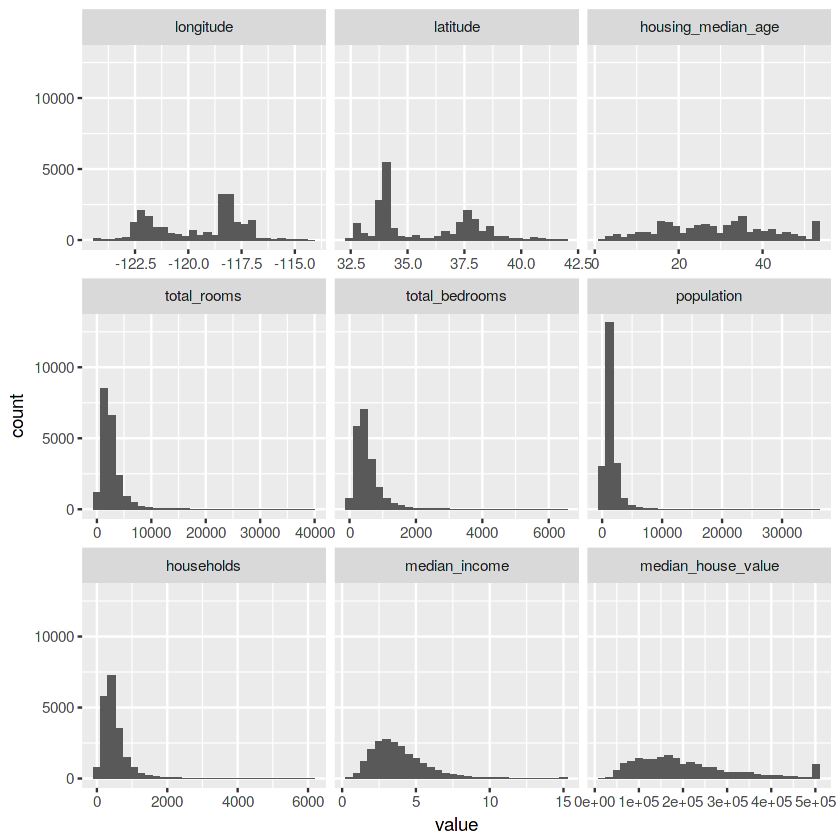

In [13]:
ggplot(data = melt(housing), mapping = aes(x = value)) + 
    geom_histogram(bins = 30) + facet_wrap(~variable, scales = 'free_x')

Things I see from this:
1. There are some housing blocks with old age homes in them.
2. The median house value has some weird cap applied to it causing there to be a blip at the rightmost point on the hist. There are most definitely houses in the bay area worth more than 500,000... even in the 90s when this data was collected!
3. We should standardize the scale of the data for any non-tree based methods. As some of the variables range from 0-10, while others go up to 500,000
4. We need to think about how the cap on housing prices can affect our prediction... may be worth removing the capped values and only working with the data we are confident in.

## Step 2. Clean the data

### Impute missing values
Fill median for total_bedrooms which is the only column with missing values. The median is used instead of mean because it is less influenced by extreme outliers. Note this may not be the best, as these could be actual buildings with no bedrooms (warehouses or something). We don't know... but imputation is often the best of a bad job

In [17]:
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

### Fix the total columns - make them means

In [18]:
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]

In [19]:
head(housing)

longitude,latitude,housing_median_age,population,households,median_income,median_house_value,ocean_proximity,mean_bedrooms,mean_rooms
-122.23,37.88,41,322,126,8.3252,452600,NEAR BAY,1.0238095,6.984127
-122.22,37.86,21,2401,1138,8.3014,358500,NEAR BAY,0.9718805,6.238137
-122.24,37.85,52,496,177,7.2574,352100,NEAR BAY,1.0734463,8.288136
-122.25,37.85,52,558,219,5.6431,341300,NEAR BAY,1.0730594,5.817352
-122.25,37.85,52,565,259,3.8462,342200,NEAR BAY,1.0810811,6.281853
-122.25,37.85,52,413,193,4.0368,269700,NEAR BAY,1.1036269,4.761658


### Turn categoricals into booleans

Below I do the following:
1. Get a list of all the categories in the 'ocean_proximity' column
2. Make a new empty dataframe of all 0s, where each category is its own colum
3. Use a for loop to populate the appropriate columns of the dataframe
4. Drop the original column from the dataframe.

This is an example of me coding R with a python accent... I would love comments about how to do this more cleanly in R!

Fun follow up task: can you turn this into a function that could be used to split any categorial column?

In [20]:
categories = unique(housing$ocean_proximity)
#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)

In [21]:
for(cat in categories){
    cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}
head(cat_housing) #see the new columns on the right

ocean_proximity,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0
NEAR BAY,0,0,0,0,0


In [22]:
for(i in 1:length(cat_housing$ocean_proximity)){
    cat = as.character(cat_housing$ocean_proximity[i])
    cat_housing[,cat][i] = 1
}

head(cat_housing)

ocean_proximity,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0
NEAR BAY,1,0,0,0,0


In [23]:
cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

tail(cat_housing)

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND
20635,0,0,1,0,0
20636,0,0,1,0,0
20637,0,0,1,0,0
20638,0,0,1,0,0
20639,0,0,1,0,0
20640,0,0,1,0,0


## Scale the numerical variables

Note here I scale every one of the numericals except for 'median_house_value' as this is what we will be working to predict. The x values are scaled so that coefficients in things like support vector machines are given equal weight, but the y value scale doen't affect the learning algorithms in the same way (and we would just need to re-scale the predictions at the end which is another hassle).

In [24]:
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

In [25]:
drops = c('ocean_proximity','median_house_value')
housing_num =  housing[ , !(names(housing) %in% drops)]

In [26]:
head(housing_num)

longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
-122.23,37.88,41,322,126,8.3252,1.0238095,6.984127
-122.22,37.86,21,2401,1138,8.3014,0.9718805,6.238137
-122.24,37.85,52,496,177,7.2574,1.0734463,8.288136
-122.25,37.85,52,558,219,5.6431,1.0730594,5.817352
-122.25,37.85,52,565,259,3.8462,1.0810811,6.281853
-122.25,37.85,52,413,193,4.0368,1.1036269,4.761658


In [27]:
scaled_housing_num = scale(housing_num)

In [28]:
head(scaled_housing_num)

longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
-1.327803,1.052523,0.9821189,-0.9744050,-0.9770092,2.34470896,-0.148510661,0.6285442
-1.322812,1.043159,-0.6070042,0.8614180,1.6699206,2.33218146,-0.248535936,0.3270334
-1.332794,1.038478,1.8561366,-0.8207575,-0.8436165,1.78265622,-0.052900657,1.1555925
-1.337785,1.038478,1.8561366,-0.7660095,-0.7337637,0.93294491,-0.053646030,0.1569623
-1.337785,1.038478,1.8561366,-0.7598283,-0.6291419,-0.01288068,-0.038194658,0.3447024
-1.337785,1.038478,1.8561366,-0.8940491,-0.8017678,0.08744452,0.005232996,-0.2697231


## Merge the altered numerical and categorical dataframes

In [29]:
cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)

In [30]:
head(cleaned_housing)

NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
1,0,0,0,0,-1.327803,1.052523,0.9821189,-0.9744050,-0.9770092,2.34470896,-0.148510661,0.6285442,452600
1,0,0,0,0,-1.322812,1.043159,-0.6070042,0.8614180,1.6699206,2.33218146,-0.248535936,0.3270334,358500
1,0,0,0,0,-1.332794,1.038478,1.8561366,-0.8207575,-0.8436165,1.78265622,-0.052900657,1.1555925,352100
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.7660095,-0.7337637,0.93294491,-0.053646030,0.1569623,341300
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.7598283,-0.6291419,-0.01288068,-0.038194658,0.3447024,342200
1,0,0,0,0,-1.337785,1.038478,1.8561366,-0.8940491,-0.8017678,0.08744452,0.005232996,-0.2697231,269700


## Step 3. Create a test set of data
We pull this subsection from the main dataframe and put it to the side to not be looked at prior to testing our models. Don't look at it, as snooping the test data introduces a bias to your work!

This is the data we use to validate our model, when we train a machine learning algorithm the goal is usually to make an algorithm that predicts well on data it hasn't seen before. To assess this feature, we pull a set of data to validate the models as accurate/inaccurate once we have completed the training process.

In [31]:
set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

I like to use little sanity checks like the ones below to make sure the manipulations have done what I want.
With big dataframes you need find ways to be sure that don't involve looking at the whole thing every step!

Note that the train data below has all the columns we want, and also that the index is jumbled (so we did take a random sample). The second check makes sure that the length of the train and test dataframes equals the length of the dataframe they were split from, which shows we didn't lose data or make any up by accident!

In [32]:
head(train)

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms,median_house_value
4975,0,1,0,0,0,0.6437155,-0.7639971,1.0615750,-0.4728430,-0.6605285,-1.36479701,0.09416648,-0.79519952,112500
13918,0,0,1,0,0,1.7567501,-0.7078161,-0.7659165,-1.1262865,-1.1600972,-0.39249525,0.11519417,-0.02182537,65600
9020,0,0,0,1,0,0.3941562,-0.6890891,-1.5604781,10.1085264,8.9751328,2.18074620,-0.11499230,0.93189653,399200
2900,0,0,1,0,0,0.2793589,-0.1225970,0.5053819,-0.8375351,-1.1993304,-1.03071303,-0.47625410,-1.01131583,47500
2764,0,0,1,0,0,1.8416002,-1.2649446,-1.0837411,-1.2137066,-1.2542568,0.07902268,2.59860572,2.00915618,32500
5786,0,1,0,0,0,0.6586891,-0.6890891,-1.1631973,0.2256351,1.0604990,0.01828013,-0.10923682,-0.54183837,200000


In [37]:
nrow(cleaned_housing)

[1] 20640

In [33]:
nrow(train) + nrow(test) == nrow(cleaned_housing)

[1] TRUE

## Step 4. Test some predictive models.

We start here with just a simple linear model using 3 of the avaliable predictors. Median income, total rooms and population. This serves as an entry point to introduce the topic of cross validation and a basic model. We want a model that makes good predictions on data that it has not seen before. A model that explains the variation in the data it was trained on well, but does not generalize to external data is referred to as being overfit. You may thin "that's why we split off some test data!" but we don't want to repeatedly assess against our test set, as then the model can just become overfit to that set of data thus moving and not solving the problem. 

So here we do cross validation to test the model using the training data itself. Our K is 5, what this means is that the training data is split into 5 equal portions. One of the 5 folds is put to the side (as a mini test data set) and then the model is trained using the other 4 portions. After that the predictions are made on the folds that was withheld, and the process is repeated for each of the 5 folds and the average predictions produced from the iterations of the model is taken. This gives us a rough understanding of how well the model predicts on external data!

In [38]:
library('boot')

In [39]:
?cv.glm # note the K option for K fold cross validation

cv.glm {boot},R Documentation
data,"A matrix or data frame containing the data. The rows should be cases and the columns correspond to variables, one of which is the response."
glmfit,"An object of class ""glm"" containing the results of a generalized linear model fitted to data."
cost,A function of two vector arguments specifying the cost function for the cross-validation. The first argument to cost should correspond to the observed responses and the second argument should correspond to the predicted or fitted responses from the generalized linear model. cost must return a non-negative scalar value. The default is the average squared error function.
K,The number of groups into which the data should be split to estimate the cross-validation prediction error. The value of K must be such that all groups are of approximately equal size. If the supplied value of K does not satisfy this criterion then it will be set to the closest integer which does and a warning is generated specifying the value of K used. The default is to set K equal to the number of observations in data which gives the usual leave-one-out cross-validation.
call,The original call to cv.glm.
K,The value of K used for the K-fold cross validation.
delta,A vector of length two. The first component is the raw cross-validation estimate of prediction error. The second component is the adjusted cross-validation estimate. The adjustment is designed to compensate for the bias introduced by not using leave-one-out cross-validation.
seed,The value of .Random.seed when cv.glm was called.


In [40]:
glm_house = glm(median_house_value~median_income+mean_rooms+population, data=cleaned_housing)
k_fold_cv_error = cv.glm(cleaned_housing , glm_house, K=5)

In [41]:
k_fold_cv_error$delta

[1] 6946162249 6942675168

The first component is the raw cross-validation estimate of prediction error. 
The second component is the adjusted cross-validation estimate.

In [42]:
glm_cv_rmse = sqrt(k_fold_cv_error$delta)[1]
glm_cv_rmse #off by about $83,000... it is a start

[1] 83343.64

In [43]:
names(glm_house) #what parts of the model are callable?

[1] "coefficients"      "residuals"         "fitted.values"    
 [4] "effects"           "R"                 "rank"             
 [7] "qr"                "family"            "linear.predictors"
[10] "deviance"          "aic"               "null.deviance"    
[13] "iter"              "weights"           "prior.weights"    
[16] "df.residual"       "df.null"           "y"                
[19] "converged"         "boundary"          "model"            
[22] "call"              "formula"           "terms"            
[25] "data"              "offset"            "control"          
[28] "method"            "contrasts"         "xlevels"

In [44]:
glm_house$coefficients 

(Intercept) median_income    mean_rooms    population 
   206855.817     82608.959     -9755.442     -3948.293

Since we scaled the imputs we can say that of the three we looked at, median income had the biggest effect on housing price... but I'm always very careful and google lots before intrepreting coefficients!

### Random forest model

In [45]:
library('randomForest')

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [46]:
?randomForest

randomForest {randomForest},R Documentation
data,an optional data frame containing the variables in the model. By default the variables are taken from the environment which randomForest is called from.
subset,"an index vector indicating which rows should be used. (NOTE: If given, this argument must be named.)"
na.action,"A function to specify the action to be taken if NAs are found. (NOTE: If given, this argument must be named.)"
"x, formula","a data frame or a matrix of predictors, or a formula describing the model to be fitted (for the print method, an randomForest object)."
y,"A response vector. If a factor, classification is assumed, otherwise regression is assumed. If omitted, randomForest will run in unsupervised mode."
xtest,a data frame or matrix (like x) containing predictors for the test set.
ytest,response for the test set.
ntree,"Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times."
mtry,Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p/3)
replace,Should sampling of cases be done with or without replacement?


In [47]:
names(train)

[1] "NEAR BAY"           "<1H OCEAN"          "INLAND"            
 [4] "NEAR OCEAN"         "ISLAND"             "longitude"         
 [7] "latitude"           "housing_median_age" "population"        
[10] "households"         "median_income"      "mean_bedrooms"     
[13] "mean_rooms"         "median_house_value"

In [48]:
set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

head(train_y)
head(train_x)

[1] 112500  65600 399200  47500  32500 200000

,NEAR BAY,<1H OCEAN,INLAND,NEAR OCEAN,ISLAND,longitude,latitude,housing_median_age,population,households,median_income,mean_bedrooms,mean_rooms
4975,0,1,0,0,0,0.6437155,-0.7639971,1.0615750,-0.4728430,-0.6605285,-1.36479701,0.09416648,-0.79519952
13918,0,0,1,0,0,1.7567501,-0.7078161,-0.7659165,-1.1262865,-1.1600972,-0.39249525,0.11519417,-0.02182537
9020,0,0,0,1,0,0.3941562,-0.6890891,-1.5604781,10.1085264,8.9751328,2.18074620,-0.11499230,0.93189653
2900,0,0,1,0,0,0.2793589,-0.1225970,0.5053819,-0.8375351,-1.1993304,-1.03071303,-0.47625410,-1.01131583
2764,0,0,1,0,0,1.8416002,-1.2649446,-1.0837411,-1.2137066,-1.2542568,0.07902268,2.59860572,2.00915618
5786,0,1,0,0,0,0.6586891,-0.6890891,-1.1631973,0.2256351,1.0604990,0.01828013,-0.10923682,-0.54183837


In [49]:
#some people like weird r format like this... I find it causes headaches
#rf_model = randomForest(median_house_value~. , data = train, ntree =500, importance = TRUE)
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

In [50]:
names(rf_model) #these are all the different things you can call from the model.

[1] "call"            "type"            "predicted"       "mse"            
 [5] "rsq"             "oob.times"       "importance"      "importanceSD"   
 [9] "localImportance" "proximity"       "ntree"           "mtry"           
[13] "forest"          "coefs"           "y"               "test"           
[17] "inbag"

In [51]:
rf_model$importance

,%IncMSE,IncNodePurity
NEAR BAY,471570753,1.386134e+12
<1H OCEAN,1589525273,3.934732e+12
INLAND,4041972795,3.010652e+13
NEAR OCEAN,505892227,2.133809e+12
ISLAND,1608344,6.900350e+10
longitude,6800888175,2.573286e+13
latitude,5404868569,2.224088e+13
housing_median_age,1101454757,9.896973e+12
population,1049908169,7.480374e+12
households,1156877777,7.922140e+12


Percentage included mean squared error is a measure of feature importance. It is defined as the measure of the increase in mean squared error of predictions when the given variable is shuffled, thereby acting as a metric of that given variable’s importance in the performance of the model. So higher number  ==  more important predictor.

### The out-of-bag (oob) error estimate
In random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. It is estimated internally, during the run, as follows:

Each tree is constructed using a different bootstrap sample from the original data. About one-third of the cases are left out of the bootstrap sample and not used in the construction of the kth tree.

In [52]:
oob_prediction = predict(rf_model) #leaving out a data source forces OOB predictions

In [53]:
#you may have noticed that this is avaliable using the $mse in the model options.
#but this way we learn stuff!
train_mse = mean(as.numeric((oob_prediction - train_y)^2))
oob_rmse = sqrt(train_mse)
oob_rmse

[1] 48976.25

So even using a random forest of only 1000 decision trees we are able to predict the median price of a house in a given district to within $49,000 of the actual median house price. This can serve as our bechmark moving forward and trying other models.

How well does the model predict on the test data?

In [54]:
test_y = test[,'median_house_value']
test_x = test[, names(test) !='median_house_value']


y_pred = predict(rf_model , test_x)
test_mse = mean(((y_pred - test_y)^2))
test_rmse = sqrt(test_mse)
test_rmse

[1] 48354.9

Well that looks great! Our model scored roughly the same on the training and testing data, suggesting that it is not overfit and that it makes good predictions.

## Step 5. Next Steps

So above we have covered the basics of cleaning data and getting a machine learning algorithm up and running in R. But I've on purpose left some room for improvement.

The obvious way to improve the model is to provide it with better data. Recall our columns:

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity

### Suggestions on ways to improve the results
Why not use your R skills to build new data! One suggestion would be to take the longitude and latitude and work with these data. You could try to find things like 'distance to closest city with 1 million people' or other location based stats. This is called feature engineering and data scientists get paid big bucks to do it effectively!

You may also wish to branch out and try some other models to see if they improve over the random forest benchmark we have set. Note this is not an exhaustive list but a starting point

Tree based methods:

gradient boosting - library(gbm)
extreme gradient boosting - library(xgb)

Other fun methods:
support vevtor machines - library(e1071)
neural networks - library(neuralnet)

### Hyperparameters and Grid search

When tuning models the next thing to worry about is the hyperparameters. All this means is the different options you pass into a model when you initialze it. i.e. the hyperparameter in out random forest model was n_tree = x, we chose x = 500, but we could have tried x = 2500, x = 1500, x = 100000 etc. 

Grid search is a common method to find the best combination of hyperparameters (as there are often more than the 1 we see in the random forest example!). Essentially this is where you make every combination of a set of paramaters and run a cross validation on each set, seeing which set gives the best predictions. An alternative is random search. When the number of hyperparameters is high then the computational load of a full grid search may be too much, so a random search takes a subset of the combinations and finds the best one in the random sample (sounds like a crapshoot but it actually works well!). These methods can be implemented easily using a for loop or two... there are also packages avaliable to help with these tasks.

Here we exit the scope of what I can cover in a short tutorial, look at the r package 'caret' it has great functions for streamling things like grid searches for the best parameters. http://caret.r-forge.r-project.org/


## Have you made a sweet model that predicts well or taught you something?
If so, you can submit the script to kaggle here: 

You can post a script or your own kernel (or fork this document and make a better version) up for the world to enjoy! I promise to upvote you if you do.

### Making your own models? Go forth with the train and test dataframes in hand to make your machine learn something!
I have also followed up on this kernel with a few sequels. Take a look at some of the other kerels produced using this dataset! [Here I expand the model through the use of gradient boosting algorithms (also in r)](https://www.kaggle.com/camnugent/gradient-boosting-and-parameter-tuning-in-r) and [here I engineer some new features and increase the prediction accuracy even more (I did this one in python).](https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization)

Also the code from this notebook has been refactored and made more R-like [here!](https://www.kaggle.com/karlcottenie/introduction-to-machine-learning-in-r-tutorial)